In [1]:
%matplotlib inline

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore")

In [1]:
from ml_util import *

/Users/arindam/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/arindam/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
maccsCount = loadNumpy('maccsCount')

In [3]:
len(maccsCount)

344

In [3]:
import feather as f

In [4]:
from IPython.display import Image

import pandas as pd
from pandas import DataFrame
from math import isnan
import numpy,pickle
from numpy import load, save,append, array,percentile,hstack,mean,abs
from sklearn.model_selection import cross_val_predict, ParameterGrid
from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.utils import shuffle
from sklearn.decomposition import TruncatedSVD as SVD
from sklearn.decomposition import PCA, NMF
from sklearn.decomposition import RandomizedPCA as RCA
from sklearn.decomposition import KernelPCA as KCA


import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import dice,hamming,jaccard,kulsinski,matching,yule,rogerstanimoto
from scipy import stats
from scipy.stats import pointbiserialr as pointbiserial
from scipy.io import savemat

In [5]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem,MACCSkeys,AtomPairs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.AtomPairs import Pairs,Torsions
from rdkit.Chem.AtomPairs.Torsions import GetTopologicalTorsionFingerprintAsIntVect as TopologicalTorsionFingerPrint
from rdkit.Chem.Draw import IPythonConsole, SimilarityMaps
from rdkit.Chem.AtomPairs.Pairs import ExplainPairScore as ExplainAtomPairScore


### Parameters for Grid Search

In [6]:
params = {"randomForest":{'min_samples_split':[5, 10, 15, 20], 'n_estimators':[100, 200], 'max_features':[0.25, 0.33], 'max_depth':[10 ,25], 'n_jobs':[-1]},
	"extraTrees":{'n_estimators':[2,3],'n_jobs':[-1]},
	"rbfSVM":{'gamma': [1e-3, 1e-4],
	                     'C': [1, 10, 100, 1000]},
	"linearSVM":{'C': [1, 10, 100, 1000]},
	"ridge":{'alpha':[0.001],'fit_intercept':[True,False],'normalize':[True],'solver':['svd'],'tol':[0.0001]},
	"dummy":{'strategy':['mean','median']},
	"LinearRegression":{'fit_intercept':[True,False],'normalize':[True,False]},	"NNGarrotteRegression":{},"KernelRegression":{},
	"KernelRidge":{'alpha':[1,10]},
	"AdaBoost":{},"Bagging":{},
	'SGDRegression': {'penalty':['l1','l2','elasticnet',None],'l1_ratio':[0.01,0.10,0.20,0.80]},
	"KNeighborsRegression":{'n_neighbors':[2,5,10],'weights':['uniform','distance'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']},
	"MultiLasso":{'alpha':[0.01,0.1,1.0,10.0]},
	"lasso":{'alpha':[0.01,0.1,1.0,10.0]},
	"DecisionTree":{'max_depth':[5,8,11]},
	"MultiElasticNet":{'alpha':[0.5,1,2],'l1_ratio':[0,0.5,1.0],'normalize':[True,False],'warm_start':[True,False]}}

### <font color="purple"> Utility Functions </font>

### Functions for generating Correlation Matrices/Plots

In [8]:
def correlationMask(X,Y,topIndices):
    length = len(X)
    d = []
    for i in range(length):
        d+= [append(X[i][topIndices],Y[i]).tolist()]
    df = pd.DataFrame(d)
    correlation = df.corr()

    # Generate a mask for the upper triangle
    mask = numpy.zeros_like(correlation, dtype=numpy.bool)
    mask[numpy.triu_indices_from(mask)] = True
    
    return correlation, mask

def correlationPlot(correlation,mask):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 6))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

### <font color="red"> Learning Function Preparation </font>

In [9]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from paulRegressor import * 

def mean_absolute_percentage_error(y_true, y_pred):
	y_true = check_arrays(y_true)
	y_pred = check_arrays(y_pred)

	return mean(abs((y_true - y_pred) / y_true)) * 100

def mape(y_true,y_pred):
    return mean_absolute_percentage_error(y_true,y_pred)

def getEstimator(regressor):

	if "lasso" in regressor or "Lasso" in regressor:
		estimator = Lasso(alpha = 0.1)#RandomForestRegressor(random_state=0, n_estimators=100)\
	elif "MultiLasso" in regressor:
		estimator = MultiLasso()
	elif "ridge" in regressor or "Ridge" in regressor:
		estimator = Ridge()#(alphas=[0.1, 1.0, 10.0])
	elif "SGDRegression" in regressor:
		estimator = SGDRegressor()
	elif "NNGarrotteRegression" in regressor:
		estimator = NNGarrotteRegressor()
	elif "KernelRegression" in regressor:
		estimator = KernelRegressor()
	elif "LinearRegression" in regressor:
		estimator = LinearRegression()
	elif "KNeighborsRegression" in regressor:
		estimator = KNeighborsRegressor()
	elif "randomForest" in regressor or "RandomForest" in regressor:
		estimator = RandomForestRegressor()
	elif "extraTrees" in regressor or "ExtraTrees" in regressor:
		estimator = ExtraTreesRegressor()
	elif "rbfSVM" in regressor or "RBFSVM" in regressor:
		estimator = SVR(kernel="rbf")
	elif "linearSVM" in regressor or "LinearSVM" in regressor:
		estimator = SVR(kernel="linear")
	elif "polySVM" in regressor or "PolySVM" in regressor:
		estimator = polySVR()
	elif "ElasticNet" in regressor:
		estimator = ElasticNet()
	elif "MultiElasticNet" in regressor:
		estimator = MultiElasticNet()
	elif "gradientBoost" in regressor or "GradientBoost" in regressor:
		estimator = gradientBoost()
	elif "AdaBoost" in regressor:
		estimator = AdaBoostRegressor()
	elif "Bagging" in regressor:
		estimator = BaggingRegressor()
	elif "DecisionTree" in regressor:
		estimator = DecisionTreeRegressor()
	elif "dummy" in regressor:
		estimator = DummyRegressor()

	return estimator
    

In [10]:
forest = RandomForestRegressor(n_jobs=-1)

In [11]:
def runReduction(X,algo='SVD',n_components=20,toFit=True):
    if algo == 'SVD' or algo=='svd': 
        model = SVD(n_components=n_components, n_iter=7, random_state=42)
    elif algo == 'PCA' or algo=='pca':
        model = PCA(n_components=n_components)
    elif algo == 'RCA' or algo=='rca':
        model = RCA(n_components=n_components)
    elif algo == 'KCA' or algo=='kca':
        model = KCA(n_components=n_components,n_jobs=-1)
    if toFit:
        return model.fit_transform(X) 
    else:
        model.fit(X) 
        return model.explained_variance_ratio_.sum()
    
def getScore(X,y,estimator=forest, CV=10,metric='all'):
    predicted = cross_val_predict(estimator, X, y, cv=CV)
    if metric=='r2':
        return r2_score(y, predicted)
    elif metric=='mse':
        return mse(y, predicted)
    elif metric=='mae':
        return mae(y, predicted)
    else:
        return r2_score(y, predicted),mse(y, predicted),mae(y, predicted),mape(y,predicted)
    
def getScoreWithFeatures(X,y,fpType,estimator=forest, CV=10,metric='all'):
    predicted = cross_val_predict(estimator, X, y, cv=CV)
    if metric=='r2':
        return r2_score(y, predicted)
    elif metric=='mse':
        return mse(y, predicted)
    elif metric=='mae':
        return mae(y, predicted)
    else:
        model = estimator.fit(X,y)
        features = model.feature_importances_
        indices = numpy.argsort(features)[::-1]
        saveNumpy(indices, fpType+'BasicCount')
        return r2_score(y, predicted),mse(y, predicted),mae(y, predicted),mape(y,predicted)

def crossVal_r2(X,y,estimator=forest,CV=10):
    predicted = cross_val_predict(estimator, X, y, cv=CV)
    return r2_score(y, predicted)

In [12]:
def GetCircularFingerprint(m):
    info={}
    fp = AllChem.GetMorganFingerprint(m,2,bitInfo=info)
    return info

### <font color = "red"> Get Count Information </font>

In [13]:
def getCountInfo(m, fpType):
#     m = Chem.MolFromSmiles(formula)
    fp = None
    if fpType=='AtomPair':
        fp = Pairs.GetAtomPairFingerprint(m)
        return fp.GetNonzeroElements()
    elif fpType=='Morgan' or fpType=='Circular':
        fp = AllChem.GetMorganFingerprint(m,2)
        return fp.GetNonzeroElements()
    elif fpType=='Topological':
        fp = Torsions.GetTopologicalTorsionFingerprint(m)
        Dict = fp.GetNonzeroElements()
        convertedDict = {}
        for elem in Dict:
            convertedDict[int(elem)] = Dict[elem]
        return convertedDict

### Extract the keys from the count information 

In [14]:
def getKeys(mol,fpType='AtomPair'):
    return getCountInfo(mol,fpType).keys()

### Generating the folded fingerprint 

In [15]:
def generateFoldedFingerprint(mols,fpType='AtomPair'):
    fpKeys,unfoldedFP = [],[]
    for mol in mols:
        fpKeys += getKeys(mol,fpType)
    fpKeys = list(set(fpKeys))
    
    ## Iterating over each molecule 
    for mol in mols:
        fpDict = getCountInfo(mol,fpType)
        keys = fpDict.keys()
        x = list(set(fpKeys)-set(keys))
        y = [0]*len(x)
        dictionary = dict(zip(x,y))
        dictionary.update(fpDict)
        List = []
        for attribute in fpKeys:
            List += [dictionary[attribute]]
        unfoldedFP += [List]
    saveData(fpKeys,fpType+'Positions')
    saveData(unfoldedFP,fpType+'FoldedCount')   
    return unfoldedFP

### Finding the submolecule for the information bit

In [16]:
def getSubMoleculeMorgan(m, atom,radius):
    env = Chem.FindAtomEnvironmentOfRadiusN(m,radius,atom)
    amap={}
    submol=Chem.PathToSubmol(m,env,atomMap=amap)
    Chem.MolToSmiles(submol)

In [17]:
mols = loadNumpy('mols')

#### <font color="red"> An example molecule </font>

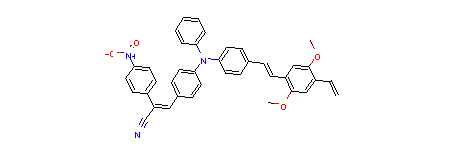

In [40]:
mols[-1]

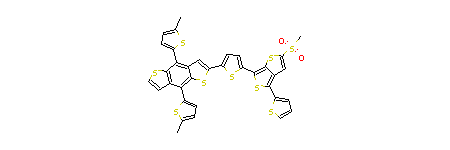

In [41]:
mols[0]    

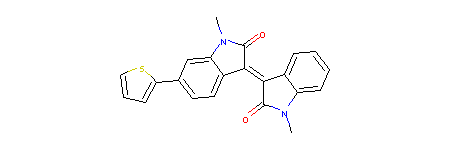

In [42]:
mols[1]    

### CircularFingerprint with Information about the Bits

In [43]:
List = []
for mol in mols:
    List += [GetCircularFingerprint(mol)]

In [44]:
saveNumpy(List, 'circularFingerprintWithInfo')

circularFingerprintWithInfo saved successfully in .


### <font color="blue"> Folding of the Unfolded Fingerprints </font>

In [46]:
ap = generateFoldedFingerprint(mols,'AtomPair')

In [48]:
topo = generateFoldedFingerprint(mols,'Topological')
morgan = generateFoldedFingerprint(mols,'Morgan')

In [10]:
x = loadNumpy('AtomPairCount')

In [49]:
saveNumpy(ap,'AtomPairCount')
saveNumpy(topo,'TopologicalCount')
saveNumpy(morgan,'MorganCount')

AtomPairCount saved successfully in .
TopologicalCount saved successfully in .
MorganCount saved successfully in .


In [16]:
apCount = loadData('AtomPairFoldedCount')
apPositions = loadData('AtomPairPositions')

In [93]:
for pos in apPositions:
    print Pairs.ExplainPairScore(pos)

(('C', 1, 0), 18, ('C', 1, 0))
(('C', 2, 1), 22, ('O', 1, 0))
(('C', 2, 0), 13, ('O', 2, 0))
(('C', 2, 1), 3, ('C', 1, 2))
(('C', 2, 1), 23, ('C', 2, 1))
(('C', 2, 1), 24, ('N', 1, 2))
(('C', 2, 1), 25, ('O', 2, 0))
(('C', 1, 0), 15, ('F', 1, 0))
(('C', 2, 1), 26, ('C', 2, 1))
(('N', 3, 0), 5, ('O', 2, 0))
(('C', 1, 0), 19, ('N', 1, 2))
(('C', 1, 0), 2, ('C', 2, 0))
(('C', 2, 1), 4, ('C', 1, 2))
(('C', 2, 1), 28, ('O', 2, 0))
(('C', 2, 2), 21, ('N', 1, 2))
(('C', 2, 1), 29, ('O', 1, 1))
(('C', 2, 2), 4, ('C', 2, 2))
(('N', 3, 0), 11, ('O', 1, 0))
(('C', 2, 1), 30, ('O', 2, 0))
(('N', 3, 0), 6, ('O', 2, 0))
(('C', 2, 1), 2, ('O', 2, 1))
(('C', 1, 0), 20, ('N', 1, 2))
(('C', 1, 0), 3, ('C', 2, 2))
(('C', 1, 0), 8, ('O', 1, 0))
(('C', 2, 1), 5, ('F', 1, 0))
(('C', 3, 1), 1, ('S', 4, 0))
(('C', 3, 1), 11, ('S', 2, 1))
(('C', 2, 2), 22, ('N', 1, 2))
(('C', 3, 1), 2, ('Si', 4, 0))
(('C', 2, 2), 5, ('C', 2, 2))
(('C', 3, 1), 3, ('C', 2, 2))
(('C', 2, 1), 9, ('C', 2, 1))
(('C', 3, 1), 4, ('F',

(('C', 3, 1), 29, ('O', 1, 1))
(('C', 3, 1), 30, ('O', 2, 0))
(('C', 2, 1), 11, ('O', 2, 1))
(('C', 2, 2), 1, ('C', 2, 2))
(('C', 2, 0), 16, ('O', 2, 0))
(('C', 1, 0), 14, ('Si', 4, 0))
(('C', 3, 1), 18, ('O', 1, 0))
(('C', 3, 1), 1, ('O', 2, 0))
(('C', 2, 2), 3, ('O', 1, 1))
(('C', 2, 2), 4, ('O', 2, 0))
(('C', 2, 1), 7, ('C', 1, 2))
(('C', 2, 1), 18, ('C', 2, 1))
(('C', 2, 2), 5, ('S', 2, 1))
(('C', 2, 2), 6, ('S', 2, 1))
(('C', 2, 0), 17, ('O', 2, 0))
(('C', 1, 0), 15, ('S', 4, 0))
(('C', 2, 2), 7, ('Si', 4, 0))
(('C', 3, 1), 2, ('O', 2, 0))
(('C', 2, 1), 17, ('N', 3, 0))
(('C', 2, 2), 8, ('S', 2, 1))
(('C', 2, 2), 9, ('O', 2, 0))
(('C', 2, 2), 10, ('O', 1, 1))
(('C', 1, 0), 7, ('C', 2, 0))
(('C', 2, 2), 11, ('N', 3, 0))
(('C', 2, 0), 1, ('C', 3, 0))
(('C', 1, 0), 16, ('C', 4, 0))
(('C', 3, 1), 20, ('N', 1, 2))
(('C', 3, 1), 3, ('O', 2, 0))
(('C', 2, 1), 18, ('N', 3, 0))
(('C', 2, 2), 13, ('N', 3, 0))
(('C', 1, 0), 13, ('N', 3, 1))
(('C', 2, 2), 14, ('O', 2, 0))
(('C', 2, 1), 4, ('N

(('N', 1, 2), 7, ('O', 2, 0))
(('C', 3, 1), 8, ('C', 1, 2))
(('C', 1, 0), 15, ('N', 2, 1))
(('N', 1, 2), 8, ('S', 2, 1))
(('N', 1, 2), 9, ('N', 1, 2))
(('N', 1, 2), 10, ('O', 2, 0))
(('N', 1, 2), 11, ('O', 1, 1))
(('C', 2, 1), 11, ('S', 2, 0))
(('C', 1, 2), 9, ('C', 2, 2))
(('C', 2, 0), 13, ('C', 2, 2))
(('N', 1, 2), 12, ('O', 2, 0))
(('C', 4, 0), 16, ('N', 2, 1))
(('C', 3, 1), 15, ('C', 1, 2))
(('C', 1, 0), 29, ('O', 1, 1))
(('C', 2, 0), 9, ('N', 2, 1))
(('C', 2, 0), 8, ('O', 2, 0))
(('N', 1, 2), 15, ('O', 1, 1))
(('O', 1, 1), 8, ('O', 1, 1))
(('N', 1, 2), 16, ('O', 2, 0))
(('S', 1, 1), 6, ('S', 2, 1))
(('N', 1, 2), 17, ('S', 2, 1))
(('C', 4, 0), 17, ('C', 2, 1))
(('S', 1, 1), 9, ('S', 2, 1))
(('S', 1, 1), 12, ('S', 2, 1))
(('C', 1, 0), 12, ('O', 2, 1))
(('C', 1, 0), 14, ('F', 1, 0))
(('S', 1, 1), 15, ('S', 2, 1))
(('S', 1, 1), 19, ('S', 2, 1))
(('N', 3, 1), 14, ('N', 1, 2))
(('S', 1, 1), 22, ('S', 2, 1))
(('S', 1, 1), 25, ('S', 2, 1))
(('S', 1, 1), 28, ('S', 2, 1))
(('N', 1, 2), 21, 

### <font color ="purple"> Learning from the fingerprints </font>

In [22]:
ap = loadNumpy('AtomPairCount')
topo = loadNumpy('TopologicalCount')
morgan = loadNumpy('MorganCount')

In [52]:
atom = ap
maccs = loadNumpy('maccsCount')

In [21]:
HOMO = loadNumpy('HOMO')

In [51]:
LUMO = loadNumpy('LUMO')
GAP = loadNumpy('GAP')

In [53]:
reg_train = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

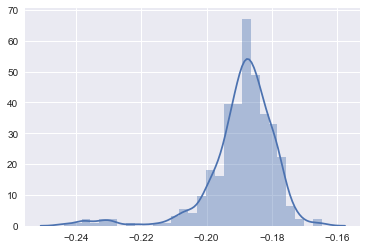

In [54]:
sns.distplot(HOMO)

In [58]:
NUM = int(0.9*344)
atomShuffle,morganShuffle, maccsShuffle,topoShuffle,HOMOShuffle = shuffle(atom,morgan,maccs,topo,HOMO)
HOMOTrain, HOMOTest = HOMOShuffle[:NUM],HOMOShuffle[NUM:]

atomTrain, atomTest = atomShuffle[:NUM],atomShuffle[NUM:] 
topoTrain, topoTest = topoShuffle[:NUM],topoShuffle[NUM:]
morganTrain, morganTest = morganShuffle[:NUM], morganShuffle[NUM:]
maccsTrain, maccsTest = maccsShuffle[:NUM], maccsShuffle[NUM:]

90 - 10 Split

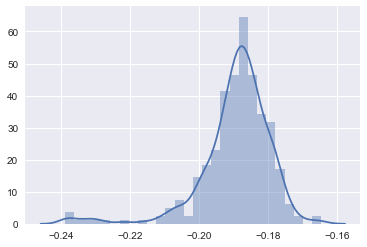

In [59]:
sns.distplot(HOMOTrain)

In [63]:
saveNumpy(HOMOTrain,'HOMO90')
saveNumpy(HOMOTest,'HOMO10')
saveNumpy(atomTrain, 'atom90')
saveNumpy(atomTest, 'atom10')
saveNumpy(topoTrain, 'topo90')
saveNumpy(topoTest , 'topo10')
saveNumpy(morganTrain, 'morgan90')
saveNumpy(morganTest , 'morgan10')
saveNumpy(maccsTrain, 'maccs90')
saveNumpy(maccsTest, 'maccs10')

HOMO90 saved successfully in .
HOMO10 saved successfully in .
atom90 saved successfully in .
atom10 saved successfully in .
topo90 saved successfully in .
topo10 saved successfully in .
morgan90 saved successfully in .
morgan10 saved successfully in .
maccs90 saved successfully in .
maccs10 saved successfully in .


#### <font color="green"> AtomPair</font>

In [156]:
atom = ap

In [21]:
getScore(ap,HOMO)

(0.61885527710633159,
 4.4816289520489457e-05,
 0.0045733406743184166,
 2.3700281862623669)

In [23]:
getScore(ap,HOMO,forest,20)

(0.65960364818516026,
 4.0024957813486932e-05,
 0.0043181484847992337,
 2.2448398840295138)

In [24]:
getScore(ap,HOMO,forest,43)

(0.66878476166844947,
 3.894541134393671e-05,
 0.0043290136908467449,
 2.2530012227038898)

In [28]:
getScore(ap,LUMO,forest,43)

(0.6627786403214162,
 8.6329199031540862e-05,
 0.0057393319535251203,
 7.2931147140901746)

In [29]:
getScore(ap,GAP,forest,43)

(0.74536308269477525,
 8.7888789101656572e-05,
 0.0064523138038589728,
 7.0928889131433897)

#### Dimensionality Reduction is performing worse

In [267]:
getScore(runReduction(atom,'PCA'),HOMO,extraTrees)

(0.60203513920388207,
 4.6794058396017181e-05,
 0.0045386439970930273,
 2.364131504084483)

In [270]:
getScore(runReduction(atom,'SVD'),HOMO,extraTrees)

(0.6387887512943855,
 4.247244400275879e-05,
 0.0043537072755167987,
 2.2587835833805814)

In [272]:
getScore(runReduction(atom,'KCA'),HOMO,extraTrees)

(0.61666069841412774,
 4.5074335528049547e-05,
 0.0046216868766149896,
 2.4077040092189694)

In [271]:
getScore(runReduction(atom,'SVD',10),HOMO,extraTrees)

(0.48368468547769738,
 6.0710106239486074e-05,
 0.0048718363808139559,
 2.5093680671869341)

#### <font color="red"> CV on the training subset 80-20 Split</font>

In [253]:
getScore(atomTrain,HOMOTrain,extraTrees)

(0.66799481178217912,
 3.7641765931528455e-05,
 0.0040036778048274987,
 2.0787689452216758)

In [254]:
getScore(atomTrain,HOMOTrain,extraTrees,20)

(0.64508548051872183,
 4.0239158128005636e-05,
 0.0040612433431457436,
 2.1033246328078592)

In [252]:
getScore(atomTrain,HOMOTrain)

(0.64514580943842081,
 4.0232318213586222e-05,
 0.0043604034646095536,
 2.2705055933413378)

#### <font color="red"> CV on the training subset 90 - 10 Split</font>

In [262]:
getScore(atomTrain,HOMOTrain)

(0.66320234153604329,
 4.1849668721165687e-05,
 0.0044595142344292715,
 2.3074097324014322)

In [263]:
getScore(atomTrain,HOMOTrain,extraTrees,20)

(0.72297740305883718,
 3.4422163037411273e-05,
 0.0038498160080306879,
 1.9979967995684567)

##### <font color="red">The difference between the two results show that there is potential for improvement in the values by performing grid search</font>

##### The difference is lesser for topo and maccs and almost negligible for morgan. So the difference is pronounced in atom 

In [26]:
getScore(ap,HOMO,reg_train)

(0.62200349705484637,
 4.4446111138861495e-05,
 0.0046008736037390276,
 2.3878776391434626)

In [62]:
getScoreWithFeatures(ap,HOMO,'atompair')

atompairBasicCount saved successfully in .


(0.66427969747886284,
 3.9475132074414275e-05,
 0.0042827867240500406,
 2.2230818819908169)

In [97]:
getScoreWithFeatures(ap,HOMO,'atompair2',extraTrees)

atompair2BasicCount saved successfully in .


(0.7285229819160588,
 3.1921188750141224e-05,
 0.0038586550730414647,
 2.0141086335496325)

In [26]:
print
print "0: RING (165)"
print
print
print "1: CTN (41) (it means C triple bond Nitrogen)"
print
print
print "2: N=O "
print
print
print "3: C=C (99)"
print
print
print "4: AROMATIC RING > 1 (125)"
print
print
print "5: HOMO value"


0: RING (165)


1: CTN (41) (it means C triple bond Nitrogen)


2: N=O 


3: C=C (99)


4: AROMATIC RING > 1 (125)


5: HOMO value


#### Top 10


In [14]:
indices = loadNumpy('atompairTraining80-20Count')[:10]

In [17]:
actualAtomIndices = []
for index in indices:
    actualAtomIndices += [apPositions[index]]

In [24]:
for i in range(len(actualAtomIndices))[:5]:
    print i,':',Pairs.ExplainPairScore(actualAtomIndices[i])
    print 
    print
print 5,': HOMO'

0 : (('C', 2, 1), 5, ('N', 1, 2))


1 : (('C', 2, 2), 6, ('N', 3, 1))


2 : (('N', 3, 1), 7, ('N', 1, 2))


3 : (('C', 3, 1), 8, ('N', 1, 2))


4 : (('C', 3, 1), 11, ('N', 1, 2))


5 : HOMO


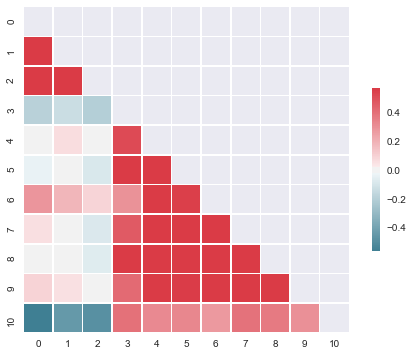

In [140]:
correlation, mask = correlationMask(ap,HOMO,indices)
correlationPlot(correlation,mask)

#### Top 5

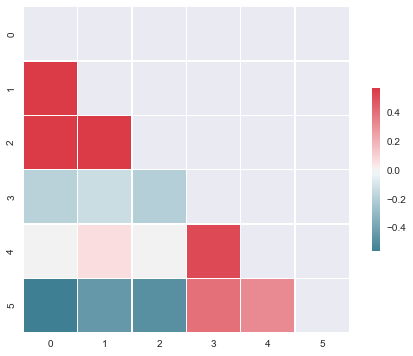

In [21]:
indices = loadNumpy('atompair2BasicCount')[:5]
correlation, mask = correlationMask(ap,HOMO,indices)
correlationPlot(correlation,mask)

In [23]:
positions = loadNumpy('atompair')

In [64]:
extraTrees = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

#### <font color="red"> 5 Fold </font>

In [72]:
getScoreWithFeatures(atom,HOMO,'atompair5Fold',extraTrees,5)

atompair5FoldBasicCount saved successfully in .


(0.70990860909700038,
 3.4109929853960684e-05,
 0.0041105726685354369,
 2.1487199756376123)

In [74]:
indices

array([ 743,  509, 2038, 2634,  443])

### <font color="blue"> Topological </font>

In [103]:
getScore(topo,HOMO)

(0.67397575264717502,
 3.8335037014641025e-05,
 0.0041618638066371425,
 2.1575833311458634)

In [110]:
getScore(topo,HOMO,43)

(0.66186986789500579,
 3.9758488012036185e-05,
 0.004179213452194205,
 2.1679134765516674)

In [117]:
getScore(topo,HOMO,reg_train)

(0.6429972863576765,
 4.1977590172902134e-05,
 0.0044503311576448218,
 2.3106003168192233)

#### Dimensionality Reduction 

In [273]:
getScore(runReduction(topo,'PCA'),HOMO,extraTrees)

(0.55214316558649912,
 5.2660525908435155e-05,
 0.0047647160965762284,
 2.4758058424793767)

In [274]:
getScore(runReduction(topo,'SVD'),HOMO,extraTrees)

(0.59300184506505449,
 4.7856223765580437e-05,
 0.0046080615261627923,
 2.4034370039783095)

In [61]:
getScoreWithFeatures(topo,HOMO,'topological')

topologicalBasicCount saved successfully in .


(0.64053650824844433,
 4.2266936810976407e-05,
 0.0043907956682013097,
 2.2860678285269462)

In [93]:
extraTrees = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=30, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [94]:
getScoreWithFeatures(topo,HOMO,'topological2',extraTrees)

topological2BasicCount saved successfully in .


(0.70162375076625194,
 3.5084091602202045e-05,
 0.0038879565221253279,
 2.0242180559385603)

In [80]:
indices = loadNumpy('topological2BasicCount')[:10]

In [81]:
indices

array([145, 294, 141, 201, 244, 129,  29,  74,  77, 224])

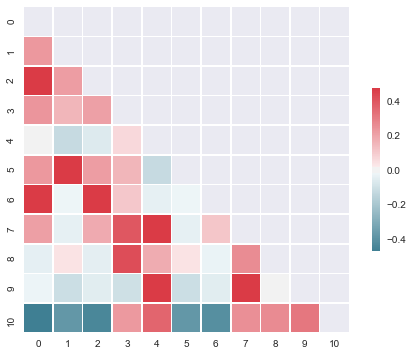

In [102]:
correlation, mask = correlationMask(topo,HOMO,indices)
correlationPlot(correlation,mask)

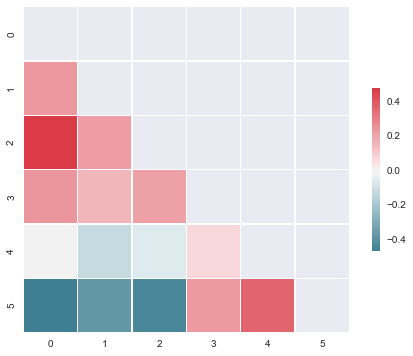

In [182]:
indices = loadNumpy('topological2BasicCount')[:5]
correlation, mask = correlationMask(topo,HOMO,indices)
correlationPlot(correlation,mask)

In [69]:
getScoreWithFeatures(topo,HOMO,'topo5Fold',extraTrees,5)

topo5FoldBasicCount saved successfully in .


(0.63590814142211904,
 4.2811155883775933e-05,
 0.0042780281173864882,
 2.2222269427960013)

### <font color="orange"> Morgan/Circular  </font>

In [104]:
getScore(morgan,HOMO)

(0.68379583541370992,
 3.7180358369115145e-05,
 0.0040960098942352859,
 2.1250737560356154)

In [108]:
getScore(morgan,HOMO,43)

(0.70585939640553885,
 3.4586050018849364e-05,
 0.0038949337090058724,
 2.0245016278265577)

In [116]:
getScore(morgan,HOMO,reg_train)

(0.68364130507858589,
 3.7198528570150694e-05,
 0.00413928658862572,
 2.1440560954592249)

In [279]:
getScore(morgan,HOMO,extraTrees)

(0.75957391829337262,
 2.8270114313105875e-05,
 0.0037299743424310979,
 1.9406884505953501)

#### Dimensionality Reduction 

In [277]:
getScore(runReduction(morgan,'PCA'),HOMO,extraTrees)

(0.72658326095563652,
 3.2149267721014181e-05,
 0.0039869734851421222,
 2.0980879226802487)

In [278]:
getScore(runReduction(morgan,'SVD'),HOMO,extraTrees)

(0.72843451996630271,
 3.1931590406293553e-05,
 0.003979542760012918,
 2.0858601292974313)

##### <font color ="purple">90-10 split</font>

In [255]:
getScore(morganTrain,HOMOTrain,extraTrees,20)

(0.63419018121052773,
 4.1474434927487203e-05,
 0.0040090348947570964,
 2.0626516767597112)

In [256]:
getScore(morganTrain,HOMOTrain,extraTrees)

(0.65831342181373276,
 3.8739413281680752e-05,
 0.0040435177167388201,
 2.0864465219355153)

In [60]:
getScoreWithFeatures(morgan,HOMO,'morgan')

morganBasicCount saved successfully in .


(0.66600895849857,
 3.9271799697338925e-05,
 0.004221715049242989,
 2.1880167970106497)

In [95]:
getScoreWithFeatures(morgan,HOMO,'morgan2',extraTrees)

morgan2BasicCount saved successfully in .


(0.76606825645741994,
 2.7506488000260123e-05,
 0.0037298170918696962,
 1.9435600377543043)

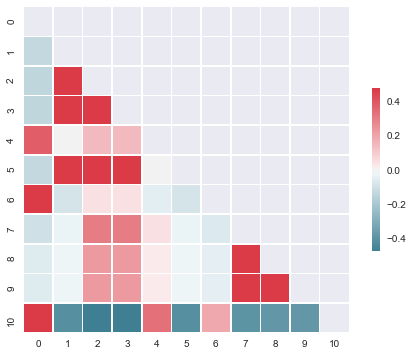

In [101]:
indices = loadNumpy('morgan2BasicCount')[:10]
correlation, mask = correlationMask(morgan,HOMO,indices)
correlationPlot(correlation,mask)

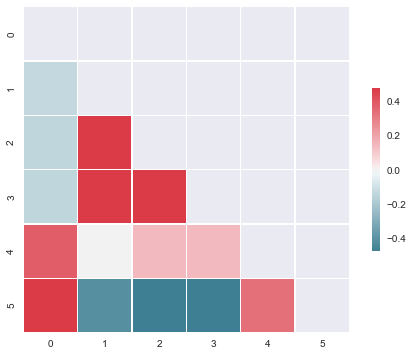

In [181]:
indices = loadNumpy('morgan2BasicCount')[:5]
correlation, mask = correlationMask(morgan,HOMO,indices)
correlationPlot(correlation,mask)

In [70]:
getScoreWithFeatures(morgan,HOMO,'morgan5Fold',extraTrees,5)

morgan5FoldBasicCount saved successfully in .


(0.72973603940432352,
 3.1778553335471626e-05,
 0.0038063593054401997,
 1.9796813878435233)

### <font color="magenta"> MACCS </font>

In [18]:
maccs = loadNumpy('maccsCount')

In [19]:
maccsBin = loadNumpy('maccsBinary')

In [23]:
getScore(maccs,HOMO)

(0.66871042281781445,
 3.8954152358182914e-05,
 0.0043403064456441487,
 2.2660545360904183)

In [142]:
crossVal_r2(maccs,HOMO)

0.67989881685757925

In [24]:
len(maccs[-1])

166

#### <font color="maroon"> There is a pronounced difference between binary and count fingerprints for MACCS </font>

In [120]:
getScore(maccsBin,HOMO)

(0.44640020439167993,
 6.5094142010167173e-05,
 0.0057724328724406788,
 3.0094539129337332)

#### Dimensionality Reduction 

In [275]:
getScore(runReduction(maccs,'PCA'),HOMO,extraTrees)

(0.70029125310802987,
 3.5240771197246337e-05,
 0.0043391937952196374,
 2.2698884553914889)

In [276]:
getScore(runReduction(maccs,'SVD'),HOMO,extraTrees)

(0.70463993896388577,
 3.472943796174969e-05,
 0.0042648194589793289,
 2.2367918469976713)

In [118]:
getScore(maccs,HOMO,reg_train)

(0.65610012372366167,
 4.0436914105093381e-05,
 0.0043405595887880712,
 2.2563171892190992)

In [146]:
getScoreWithFeatures(maccs,HOMO,'MACCS')

MACCSBasicCount saved successfully in .


(0.70164064801343007,
 3.5082104766556291e-05,
 0.0042260705092452798,
 2.2061674434734466)

In [96]:
getScoreWithFeatures(maccs,HOMO,'MACCS2',extraTrees)

MACCS2BasicCount saved successfully in .


(0.75153111658676885,
 2.9215814222322778e-05,
 0.0038222948708010345,
 1.9967115016165988)

##### <font color ="orange">80-20 split</font>

In [257]:
getScore(maccsTrain,HOMOTrain,extraTrees)

(0.68006932601549186,
 3.6272793232797387e-05,
 0.0042000455535353542,
 2.1975701969077996)

In [258]:
getScore(maccsTrain,HOMOTrain)

(0.63821393852094066,
 4.1018233228782213e-05,
 0.004336226128209165,
 2.2517579153660812)

##### <font color ="purple">90-10 split</font>

In [264]:
getScore(maccsTrain,HOMOTrain,extraTrees)

(0.76864173012109793,
 2.8748023351742736e-05,
 0.0038686555409154009,
 2.0201844767866945)

In [265]:
getScore(maccsTrain,HOMOTrain)

(0.61976666361124577,
 4.7246881813805286e-05,
 0.0045600166013930327,
 2.3748267244528258)

#### Correlation Analysis

In [25]:
indices = loadNumpy('MACCS2BasicCount')[:10]

In [29]:
indices[:5]

array([164,  40,  75, 124,  61])

### Adjustment because indices in MACCS signature is from 1-166 and not 0-165
http://www.mayachemtools.org/docs/modules/html/MACCSKeys.html

In [28]:
adjusted = []
for index in indices:
    adjusted += [index+1]
array(adjusted)

array([165,  41,  76, 125,  62,  99,  63,  56,  80,  71])

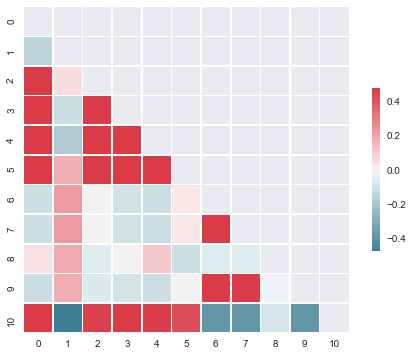

In [112]:
correlation, mask = correlationMask(maccs,HOMO,indices)
correlationPlot(correlation,mask)

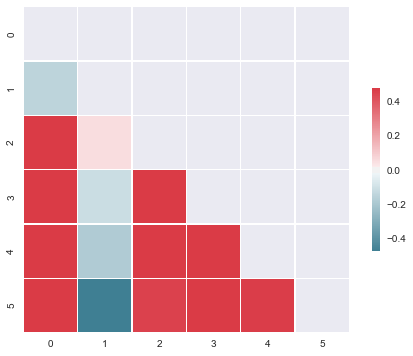

In [180]:
indices = loadNumpy('MACCS2BasicCount')[:5]
correlation, mask = correlationMask(maccs,HOMO,indices)
correlationPlot(correlation,mask)

In [71]:
getScoreWithFeatures(maccs,HOMO,'maccs5Fold',extraTrees,5)

maccs5FoldBasicCount saved successfully in .


(0.73281762683420593,
 3.1416209831429872e-05,
 0.0039108841424418611,
 2.0470288961227019)

In [53]:
HOMO_scaled = scale(HOMO)
maccs_scaled = scale(maccs)

#### <font color="red"> The mse, mae and mape are going crazy up on scaling </font>

In [52]:
getScore(maccs,HOMO_scaled)

(0.68452876917690553,
 0.31547123082309453,
 0.39012496074819053,
 1658.6155402381819)

In [54]:
getScore(maccs_scaled,HOMO_scaled)

(0.69171383323092206,
 0.30828616676907789,
 0.39113074103013884,
 2185.5466811957908)

### <font color="crimson"> Standardized Fingerprints and Labels </font>

In [187]:
maccs_standard = StandardScaler().fit_transform(maccs)

In [193]:
maccs_normal = normalize(maccs)

In [191]:
HOMO_standard = StandardScaler().fit_transform(HOMO)

In [190]:
getScore(maccs_standard,HOMO,extraTrees)

(0.75647841129734528,
 2.8634094526955938e-05,
 0.0037722842781007754,
 1.9751874970732786)

In [192]:
getScore(maccs_standard,HOMO_standard,extraTrees)

(0.75298573360567544,
 0.24701426639432456,
 0.35081353697278417,
 2171.7255121307508)

In [195]:
getScore(normalize(maccs),HOMO_standard,extraTrees)

(0.77193572128213495,
 0.22806427871786511,
 0.34059589630893333,
 1686.8145512914293)

#### Morgan

In [197]:
getScore(StandardScaler().fit_transform(morgan),HOMO_standard,extraTrees)

(0.77578847051979805,
 0.22421152948020195,
 0.33591794943993186,
 1426.8836890445089)

In [198]:
getScore(StandardScaler().fit_transform(morgan),HOMO,extraTrees)

(0.74971798997237937,
 2.9429007800528116e-05,
 0.0036724416742801779,
 1.9057964040058131)

#### Topological

In [200]:
getScore(StandardScaler().fit_transform(topo),HOMO_standard,extraTrees)

(0.69449684971415437,
 0.30550315028584563,
 0.36253401273197366,
 2135.4801599478569)

#### AtomPair

In [201]:
getScore(StandardScaler().fit_transform(atom),HOMO_standard,extraTrees)

(0.7364697674445051,
 0.26353023255549485,
 0.34989659631556941,
 2494.5624624493353)

### <font color="purple"> Mixed Fingerprint</font>

In [171]:
maccsAtom = hstack((maccs,atom))

maccsMorganCount saved successfully in .


In [179]:
saveNumpy(maccsAtom,'maccsAtomCount')

maccsAtomCount saved successfully in .


In [160]:
getScore(maccsAtom,HOMO,extraTrees)

(0.750111115460385,
 2.9382782772001973e-05,
 0.0036849562791466711,
 1.9235225094122455)

In [163]:
maccsMorgan = hstack((maccs,morgan))

In [164]:
getScore(maccsMorgan,HOMO,extraTrees)

(0.78378048069578132,
 2.542382458702512e-05,
 0.0034920834555724743,
 1.8190513968513713)

In [ ]:
getScore(StandardScaler().fit_transform(maccsMorgan),HOMO,extraTrees)

In [174]:
getScore(maccsMorgan,HOMO,extraTrees,43)

(0.7836999168780594,
 2.5433297554019112e-05,
 0.0035041655156423045,
 1.8225009841053277)

In [165]:
maccsTopo = hstack((maccs,topo))

In [175]:
saveNumpy(maccsTopo,'maccsTopoCount')

maccsTopoCount saved successfully in .


In [166]:
getScore(maccsTopo,HOMO,extraTrees)

(0.76246288738697243,
 2.7930419526486374e-05,
 0.0036583938385935776,
 1.9044858104639695)

In [173]:
getScore(maccsTopo,HOMO,extraTrees,43)

(0.75644067218329547,
 2.8638532020012811e-05,
 0.0035790888028331518,
 1.859281778782063)

In [161]:
atomTopo = hstack((atom,topo))

In [178]:
saveNumpy(atomTopo,'atomTopoCount')

atomTopoCount saved successfully in .


In [162]:
getScore(atomTopo,HOMO,extraTrees)

(0.72816510243160404,
 3.1963269434000615e-05,
 0.0038757041760874296,
 2.0202683637950116)

In [167]:
atomMorgan = hstack((atom,morgan))

In [168]:
getScore(atomMorgan,HOMO,extraTrees)

(0.74040584835972834,
 3.052396100203103e-05,
 0.0037833977927006785,
 1.9729374351440441)

In [177]:
saveNumpy(atomMorgan,'atomMorganCount')

atomMorganCount saved successfully in .


In [169]:
morganTopo = hstack((morgan,topo))

In [170]:
getScore(morganTopo,HOMO,extraTrees)

(0.75115841849151455,
 2.925963732871092e-05,
 0.0036788653507982719,
 1.9141793867580681)

In [176]:
saveNumpy(morganTopo,'morganTopoCount')

morganTopoCount saved successfully in .


### <font color="magenta"> Feature Reduction </font>

In [119]:
def reduceFeatures(X,y,estimator=forest):
    if len(X[-1])<400:
        NUM = 15
    elif len(X[-1])<2000:
        NUM = 100
    else:
        NUM = 200
    
    for iter in range(10):
        model = estimator.fit(X,y)
        features = model.feature_importances_
        indices = numpy.argsort(features)[::-1]
        top = indices[:-NUM]
        modX = []
        for i in range(len(X)):
            vector = []
            count = 0
            for j in range(len(X[0])):
                if j in top:
                    vector += [X[i][count]]
                    count += 1
            modX += [vector]
        print crossVal_r2(modX,y), len(X[0])
        X = modX
        

### <font color="pink"> Feature Exploration </font>

In [153]:
def topFeatures(X,y,num, estimator=extraTrees):
    model = estimator.fit(X,y)
    features = model.feature_importances_
    indices = numpy.argsort(features)[::-1]
    for i in range(num):
        print 'index:',indices[i],'contribution:',features[indices[i]]
    #return indices[:20]

#### Atom Pair

In [136]:
topFeatures(ap,HOMO)

index: 743 contribution: 0.141922830222
index: 509 contribution: 0.0734816837276
index: 2038 contribution: 0.0360934231556
index: 2016 contribution: 0.0318903713163
index: 2634 contribution: 0.0271364139833


#### Topological

In [137]:
topFeatures(topo,HOMO)

index: 145 contribution: 0.114844082684
index: 294 contribution: 0.0737731757258
index: 201 contribution: 0.066088153016
index: 29 contribution: 0.05569340408
index: 129 contribution: 0.0548669723948


#### Morgan

In [138]:
top5(morgan,HOMO)

index: 804 contribution: 0.207600703207
index: 459 contribution: 0.0689902107464
index: 806 contribution: 0.0594806577955
index: 1100 contribution: 0.0416100249089
index: 665 contribution: 0.0263743526675


#### MACCS

In [286]:
topFeatures(maccs,HOMO,5)

index: 164 contribution: 0.196566770506
index: 40 contribution: 0.146287435342
index: 75 contribution: 0.0832006540462
index: 98 contribution: 0.0684039383011
index: 62 contribution: 0.0391084923579


In [287]:
topFeatures(maccs,HOMO,10)

index: 40 contribution: 0.133321077249
index: 164 contribution: 0.133125228264
index: 75 contribution: 0.0871969943572
index: 124 contribution: 0.0856958683121
index: 98 contribution: 0.0566407480769
index: 62 contribution: 0.0381394970715
index: 61 contribution: 0.0331720040972
index: 79 contribution: 0.0293470979571
index: 70 contribution: 0.0260050012253
index: 69 contribution: 0.0210977444497


In [288]:
maccsShort10 = []
indices = [164,40,75,124,98,62,61,79,70,69]
for i in range(344):
    short = []
    for index in indices:
        short += [maccs[i][index]]
    maccsShort10 += [short]

### Regression on the top 5 and 10 features 

In [284]:
getScore(maccsShort,HOMO,extraTrees)

(0.68565326534701398,
 3.6961955456376412e-05,
 0.0042806485775424572,
 2.2481480068527984)

In [290]:
getScore(maccsShort,HOMO)

(0.68418444380924637,
 3.7134664475645406e-05,
 0.0043681156910555536,
 2.2875556568219735)

In [289]:
getScore(maccsShort10,HOMO,extraTrees)

(0.69403701613830893,
 3.5976165597139329e-05,
 0.0042093514747139262,
 2.2046720801117665)

In [291]:
getScore(maccsShort10,HOMO)

(0.67795273119509702,
 3.7867410385398226e-05,
 0.004399532992590752,
 2.2987972668919396)

### <font color="green"> Staged Reduction </font>

#### AtomPair

In [82]:
reduceFeatures(ap,HOMO)

(0.65756372655116624, 4.0264818719481146e-05, 0.0044813358759280136, 2.3279328709775964)
(0.66786203709517311, 3.9053908429531042e-05, 0.0045150618889540691, 2.3528394059944104)
(0.63408812055360708, 4.3025160111769196e-05, 0.0044603111477377524, 2.310782597876567)
(0.66516812711788953, 3.9370667503531809e-05, 0.0044471112781299784, 2.3178467152152895)
(0.66854558562973598, 3.8973534473954021e-05, 0.0043903894231934427, 2.2852360401679022)
(0.64183453972769189, 4.2114309866179655e-05, 0.0044427031228413067, 2.3067048491501185)
(0.59362409485702572, 4.7783057524108361e-05, 0.0047367521316643646, 2.4594397317320538)
(0.61645203876453036, 4.5098870437510191e-05, 0.004591158423749216, 2.3826877774572677)
(0.63562158693496462, 4.2844849932488476e-05, 0.0046112398830667079, 2.3895410197505895)
(0.56448942503350419, 5.1208810838969476e-05, 0.0048176115183919772, 2.4956184878419094)


In [117]:
reduceFeatures(ap,HOMO,extraTrees)

0.651771576182 2676
0.64738600736 2476
0.631147823452 2276
0.675257957618 2076
0.653063394008 1876
0.623874489771 1676
0.636166488106 1476
0.630440967239 1276
0.600226412143 1076
0.59255504393 876


#### Topological

In [122]:
reduceFeatures(topo,HOMO)

0.631437379973 318
0.647325056388 303
0.686185635952 288
0.662832223623 273
0.643257335301 258
0.630239246013 243
0.613448181485 228
0.559864185728 213
0.57995143059 198
0.593062687717 183


In [123]:
reduceFeatures(topo,HOMO,extraTrees)

0.658879938303 318
0.670449375403 303
0.654356077966 288
0.637198555008 273
0.629564937202 258
0.649370328892 243
0.67424156887 228
0.588727979708 213
0.564330460823 198
0.536367199247 183


#### Morgan

In [86]:
reduceFeatures(morgan,HOMO)

0.697554498156 1193
0.733469954257 1093
0.708201002805 993
0.604796391953 893
0.661298819406 793
0.589284977369 693
0.62595138685 593
0.583576492105 493
0.625546756698 393
0.326855281257 293


In [115]:
reduceFeatures(morgan,HOMO,extraTrees)

0.706892306243 1193
0.686575080668 1093
0.693695471242 993
0.664590589966 893
0.653948463023 793
0.626362781738 693
0.616934078438 593
0.63023447345 493
0.593012449717 393
0.340541929268 293


#### MACCS

In [121]:
reduceFeatures(maccs,HOMO)

0.676130421137 166
0.689310579486 151
0.733717161328 136
0.737140333976 121
0.689810435111 106
0.727393980219 91
0.621205642819 76
0.578783894545 61
0.153076085882 46
-0.00775586830302 31


In [120]:
reduceFeatures(maccs,HOMO,extraTrees)

0.739021409017 166
0.739154031213 151
0.705239817623 136
0.725535852344 121
0.729010825549 106
0.699741951568 91
0.61190847668 76
0.512748037505 61
0.162652672112 46
-0.00831933051448 31


### Combined Fingerprints 

In [172]:
reduceFeatures(maccsMorgan,HOMO,extraTrees)

0.712122741277 1359
0.708251829316 1259
0.678845370245 1159
0.678688239577 1059
0.682663578121 959
0.69520338565 859
0.703878962358 759
0.675981558494 659
0.662351419544 559
0.670375888581 459


### <font color="red">Leave One Out</font>

In [91]:
def leaveOneOut(X_full,y_full,estimator=forest):
	y_predict = []
	loo = cross_validation.LeaveOneOut(len(X_full))
	for train_index, test_index in loo:
	 	X_train, X_test = X_full[train_index], X_full[test_index]
	 	y_train, y_test = y_full[train_index], y_full[test_index]
	 	y_predict += [estimator.fit(X_train, y_train).predict(X_test)]
        return r2_score(y_full, y_predict)
	

In [92]:
leaveOneOut(morgan,HOMO)

0.71709460044278872

### Saving arrays in .mat format to be used in MATLAB and R

In [36]:
savemat('atompairCount.mat',{'data':ap})

In [40]:
savemat('topologicalCount.mat',{'data':topo})
savemat('maccsCount.mat',{'data':maccs})
savemat('morganCount.mat',{'data':morgan})

In [41]:
savemat('HOMO.mat',{'data':HOMO})

### <font color="orange"> Extracting Experimental Information </font>

In [159]:
lines = open('HOPV_15.data').readlines()
NAN = 'nan,nan,nan,nan,nan,nan,nan'

In [163]:
experimentLineNums = []
for i in range(len(lines)):
    if 'molecule' in lines[i] or 'polymer' in lines[i]:
        experimentLineNums +=[i]

In [113]:
def kekule(compound):
    return Chem.MolToSmiles(Chem.MolFromSmiles(compound),kekuleSmiles=True)

In [164]:
compoundSMILES = []
for i in experimentLineNums:
    compoundSMILES += [lines[i+1].split('\n')[0]]

In [76]:
for compound in compoundSMILES:
    Chem.MolFromSmiles(compound)

In [214]:
extractedLineNumMax = []
for i in range(len(lines)):
    if 'Conformer 1\n' in lines[i]:
        extractedLineNumMax +=[i-1]

In [217]:
DFT = 'QChem B3LYP/def2-SVP DFT,-0.187,-0.099,0.088,1.56454461973,0.4885289015,49.2884633879'

In [220]:
DFT.split(',',5)[4]

'1.56454461973'

In [77]:
data = pd.read_csv('allFunctionals.csv','|')
SMILES = []
for SMILE in data['Unnamed: 1'][1:]:
    SMILES += [SMILE]

In [127]:
standardSMILES = []
for SMILE in data['Unnamed: 2'][1:]:
    standardSMILES += [SMILE]

In [221]:
compoundType, experimentHOMO,experimentPCE = [],[],[]
for lit in data['Unnamed: 4'][1:]:
    compoundType += [lit.split(',',3)[2]]
    experimentHOMO += [float(lit.split(',',6)[5])/27.211]
    experimentPCE += [float(lit.split(',',10)[9])]

In [222]:
indices = []
for i in range(len(experimentPCE)):
    if isnan(experimentPCE[i]):
        indices+=[i]

In [224]:
len(indices)

7

In [213]:
literature[3].split(',',10)[9]

'1.51'

In [191]:
nan

nan

In [173]:
literature[0].split(',',6)[5]

'-5.04'

In [194]:
from collections import Counter
indices = []
for i in range(len(compoundType)):
    if 'nan' in compoundType[i]:
        indices += [i]

In [153]:
indices

[17, 79, 268]

In [165]:
kekuleSMILES, kekuleCompounds = [],[]
for SMILE in SMILES:
    kekuleSMILES += [kekule(SMILE)]
for compoundSMILE in compoundSMILES:
    kekuleCompounds += [kekule(compoundSMILE)]

In [128]:
kekuleStandard = []
for SMILE in standardSMILES:
    kekuleStandard += [kekule(SMILE)]

In [166]:
count = 0
for i in range(len(SMILES)):
    for j in range(len(compoundSMILES)):
        if kekuleStandard[i] == kekuleCompounds[j]:
            count +=1
            

In [209]:
expHOMO = []
for lit in literature:
    expHOMO += [float(lit.split(',',6)[5])/27.211]

In [210]:
indices = []
for i in range(len(expHOMO)):
    if isnan(expHOMO[i]):
        indices+=[i]

In [211]:
len(indices)

101

In [90]:
compoundSMILES[28], SMILES[29]

('COCc1cc2csc(-c3cc4c(s3)c(OC)c3ccsc3c4OC)c2s1',
 'COCc1cc2csc(c3cc4c(s3)c(OC)c3ccsc3c4OC)c2s1')

In [95]:
if Chem.MolFromSmiles(compoundSMILES[28]) == Chem.MolFromSmiles(SMILES[29]):
    print "True"

In [99]:
a = Chem.MolToSmiles(Chem.MolFromSmiles(compoundSMILES[28]),kekuleSmiles=True)

In [100]:
b = Chem.MolToSmiles(Chem.MolFromSmiles(SMILES[29]),kekuleSmiles=True)

In [106]:
Chem.MolToSmiles(Chem.MolFromSmiles(SMILES[29]),kekuleSmiles=True)

'COCC1:C:C2:C:S:C(C3:C:C4:C(OC):C5:S:C:C:C:5:C(OC):C:4:S:3):C:2:S:1'

In [111]:
c = SMILES[29]

In [157]:
len(experimentLineNums)

350